# Gaussian Process Distribution of Relaxation Times. 
## In this tutorial we will reproduce Figure 10 of the article https://doi.org/10.1016/j.electacta.2019.135316

This tutorial shows how the GP-DRT model can recover DRT from the impedance including an inductance at high frequency.

The impedance is similar to that `ex1_simple_ZARC_model.ipynb`, except for the presence of an inductor with $L_{0}=500~\mu\rm {H}$. The DRT is identical

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
from scipy.optimize import minimize
%matplotlib inline

## 1) Define parameters of the ZARC circuit

In [2]:
# define the frequency range
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define the frequency range used for prediction
freq_vec_star = np.logspace(-4., 4., num=81, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# parameters for ZARC model
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.
L_0 = 5E-4

C = tau_0**phi/R_ct
Z_exact = R_inf + 1j*(2*pi*freq_vec)*L_0 + 1./(1./R_ct+C*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau/tau_0))-cos((1.-phi)*pi))

# used for plotting only
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
# for plotting only
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_plot/tau_0))-cos((1.-phi)*pi))

# adding random noise to the impedance
rng = np.random.seed(214974)
sigma_n_exp = 0.5
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

## 2) show the synthetic impedance in a Nyquist plot. 
### Note: this is similar to Figure 10 (a)

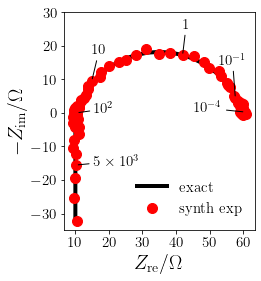

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Nyquist plot of impedance together with labeled frequency points
fig, ax = plt.subplots()
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="red", label="synth exp")
plt.annotate(r'$10^{-4}$', xy=(np.real(Z_exp[0]), -np.imag(Z_exp[0])), 
             xytext=(np.real(Z_exp[0])-15, -np.imag(Z_exp[0])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-5, 10-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30]), 8-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40]), 8-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^2$', xy=(np.real(Z_exp[60]), -np.imag(Z_exp[60])), 
             xytext=(np.real(Z_exp[60])+5, -np.imag(Z_exp[60])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$5\times 10^3$', xy=(np.real(Z_exp[77]), -np.imag(Z_exp[77])), 
             xytext=(np.real(Z_exp[77])+5, -np.imag(Z_exp[77])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(-30, 40, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 3) Compute the optimal hyperparameters

In [4]:
# initialize the parameters to minimize the negative marginal log-likelihood, see eq (31)
sigma_n = sigma_n_exp
sigma_f = 5.6
ell = 0.9
sigma_L = 3E-4

theta_0 = np.array([sigma_n, sigma_f, ell, sigma_L])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}  {3:.7f}'.format(theta[0], theta[1], theta[2], theta[3]))
    
print('sigma_n,   sigma_f,   ell,       sigma_L')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_f, ell using the BFGS method as implemented in scipy
res = minimize(GP_DRT.NMLL_fct_L, theta_0, args=(Z_exp, xi_vec), method='BFGS', \
               jac=GP_DRT.grad_NMLL_fct_L, callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_f, ell, sigma_L = res.x

sigma_n,   sigma_f,   ell,       sigma_L
0.4999994  5.6000000  0.9000003  0.0007129
0.4783180  5.5996571  0.9093610  0.0007138
0.4784722  5.5971341  0.9761654  0.0007134
0.4786302  5.5398552  1.1156550  0.0007052
0.4806697  5.5553961  1.4395532  0.0006567
0.4814963  5.7338434  1.3170056  0.0006469
0.4811801  5.7848347  1.3435225  0.0006199
0.4810202  5.8622583  1.3707405  0.0005578
0.4810493  5.8534375  1.3638917  0.0005450
0.4811226  5.8227503  1.3537372  0.0005396
0.4811214  5.8165253  1.3536523  0.0005392
0.4811196  5.8137873  1.3537183  0.0005394
0.4811197  5.8138615  1.3537392  0.0005393
0.4811196  5.8138589  1.3537368  0.0005393
Optimization terminated successfully.
         Current function value: 19.343917
         Iterations: 14
         Function evaluations: 23
         Gradient evaluations: 23


## 4) Core of the GP-DRT

### 4a) Compute matrices

In [5]:
# calculate the matrices shown in eq (38)
K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
h_L = GP_DRT.compute_h_L(xi_vec)
Sigma = (sigma_n**2)*np.eye(N_freqs)

### 4b) Factorize the matrices and solve the linear equations

In [6]:
# the matrix in (38), $\mathcal L^2_{\rm im}\mathbf K+\sigma_n^2\mathbf I+\sigma_n^2 \mathbf{h} \mathbf{h}^\top$ 
# whose inverse is needed
K_im_full = L2_im_K + Sigma + (sigma_L**2)*np.outer(h_L, h_L)

# Cholesky factorization, L is a lower-triangular matrix
L = np.linalg.cholesky(K_im_full)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)

### 4c) Predict the imaginary part of the GP-DRT and impedance

In [7]:
# initialize the imaginary part of impedance vector
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

# calculate the imaginary part of impedance at each $\xi$ point for the plot
for index, val in enumerate(xi_vec_star):
    xi_star = np.array([val])

    # compute matrices shown in eq (40), xi_star corresponds to a new point
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star_up = GP_DRT.matrix_L_im_K(xi_star, xi_vec, sigma_f, ell)
    L2_im_k_star_up = GP_DRT.matrix_L2_im_K(xi_vec, xi_star, sigma_f, ell)
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # assemble the matrix for equation (41)
    L2_im_k_star_up = L2_im_k_star_up.T + (sigma_L**2)*(GP_DRT.compute_h_L(xi_star))*h_L.T
    L2_im_k_star_star  = L2_im_k_star_star + (sigma_L**2)*(GP_DRT.compute_h_L(xi_star)**2)
    
    # compute Z_im_star mean and standard deviation following eq (26)
    Z_im_vec_star[index] = np.dot(L2_im_k_star_up, np.dot(inv_K_im_full,Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star-np.dot(L2_im_k_star_up, np.dot(inv_K_im_full, L2_im_k_star_up.T))
    
    # compute gamma_star mean and standard deviation following eq (47)
    gamma_vec_star[index] = np.dot(L_im_k_star_up, np.dot(inv_K_im_full,Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star-np.dot(L_im_k_star_up, np.dot(inv_K_im_full, L_im_k_star_up.T))

### 4d) Plot the obtained GP-DRT against the analytical DRT

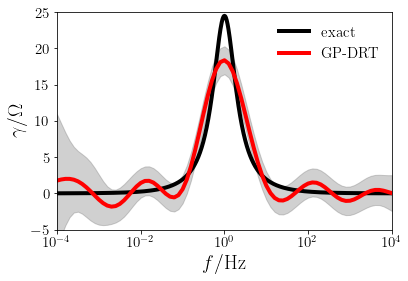

In [8]:
# plot the DRT and its confidence region
plt.semilogx(freq_vec_plot, gamma_fct_plot, linewidth=4, color="black", label="exact")
plt.semilogx(freq_vec_star, gamma_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, gamma_vec_star-3*np.sqrt(abs(Sigma_gamma_vec_star)), gamma_vec_star+3*np.sqrt(abs(Sigma_gamma_vec_star)), color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

### 4e) Plot the imaginary part of the GP-DRT impedance together with the exact one and the synthetic experiment

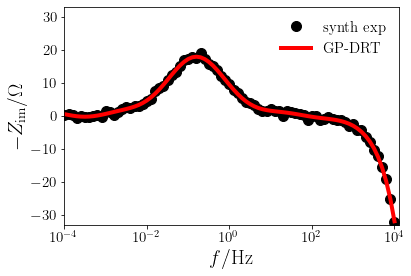

In [9]:
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1.3E4,-33,33])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

### 4f) Estimate the inductance $L_{0}$

In [10]:
# the inductance is predicted using equation (44a) 
K_im_full_reg = L2_im_K + Sigma

# covariance matrix $\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I$
L = np.linalg.cholesky(K_im_full_reg)
inv_L = np.linalg.inv(L)
inv_K_im_full_reg = np.dot(inv_L.T, inv_L)

# the numerator and denominator of the equation (44a)
num_L_0 = np.dot(np.dot(inv_K_im_full_reg, Z_exp.imag), h_L)
den_L_0 = (sigma_L**-2) + np.dot(h_L.T, np.dot(inv_K_im_full_reg, h_L))

L_0_est = num_L_0/den_L_0
print('estimated L_0 = {0:.6f} H'.format(L_0_est[0][0]))
print('relative error = {0:.2f} %'.format((L_0_est[0][0]-L_0)/L_0*100.))

estimated L_0 = 0.000537 H
relative error = 7.44 %
